In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_raw = pd.read_csv('coords_filtered.csv', header=None, sep=";")
df_raw.columns = ["code", "Name", "Latitude", "Longitude", "desc"]

In [36]:
# randomly subsample 1000 indices
df_sampled = df_raw.sample(n=len(df_raw), random_state=42, replace=True)
df = df_sampled.copy()

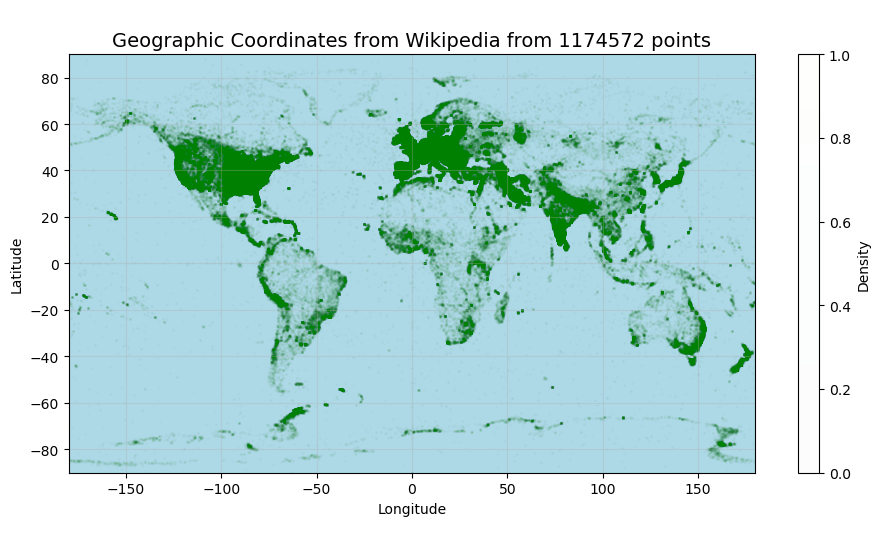

In [61]:
# Full version with labels and formatting
import pandas as pd
import matplotlib.pyplot as plt


# Create 947x553 pixel plot
plt.figure(figsize=(9.47, 5.53), dpi=100)

# Background blue
plt.gca().set_facecolor('lightblue')

# Plot points
plt.scatter(df['Longitude'], df['Latitude'], c='green', s=1, alpha=0.01)

# Format plot
plt.xlabel('Longitude\n')
plt.ylabel('Latitude')
plt.title(f'\nGeographic Coordinates from Wikipedia from {len(df_raw)} points', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# add colorbar
plt.colorbar(label='Density')

# y-ticks every 20, from 80 to -80
plt.yticks(np.arange(-80, 81, 20))
# Limit at 90
plt.ylim(-90, 90)

# limit at 160
plt.xlim(-180, 180)

# Save to figure
plt.savefig('coords_sampled.png', dpi=300, bbox_inches='tight')
plt.savefig('image1.png', dpi=300, bbox_inches='tight')

Loading images...
Image 1 size: (2637, 1622)
Image 2 size: (947, 553)
Target size (from img1): (2637, 1622)
Image 2 padding: 65px top, 20px right, 45px bottom, 0px left
Image 1 alpha: 1.0 (opacity)
Image 2 alpha: 1.0 (opacity)
Image 1 linger frames: 5
Image 2 linger frames: 3
Creating fade frames...
Displaying static preview...


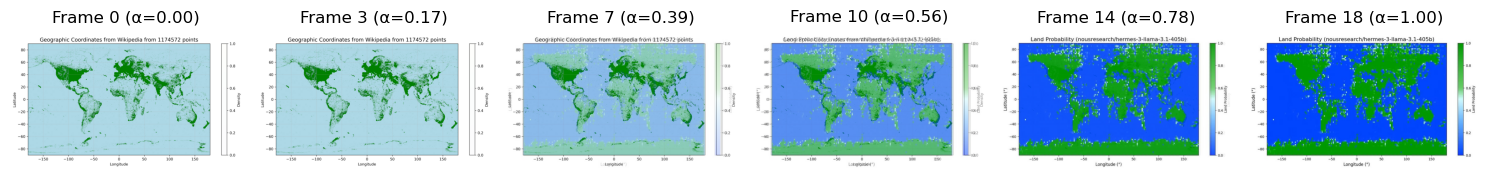

Creating animation...


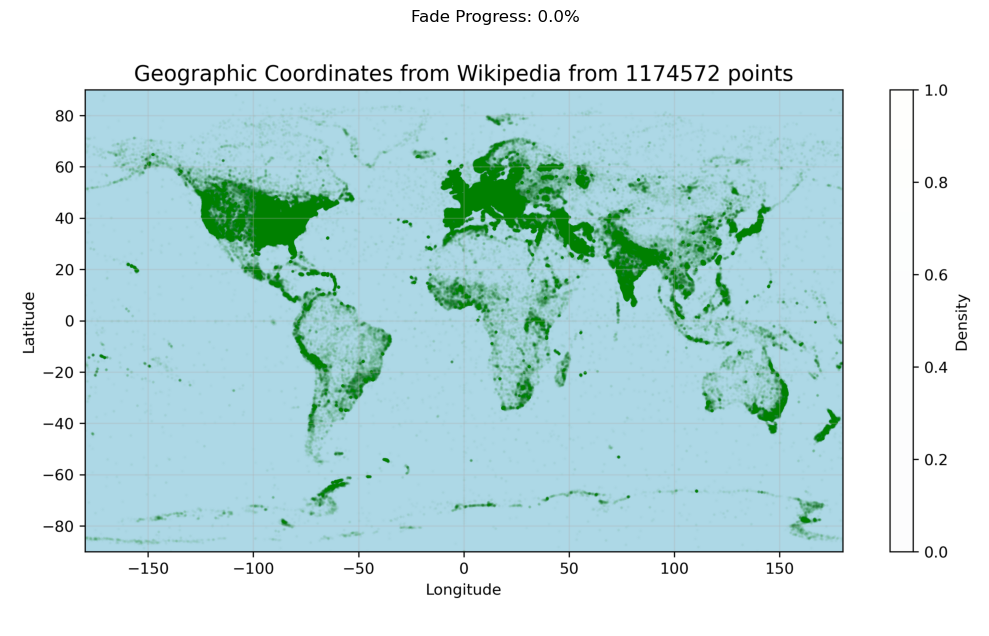

Resizing frames from 2637x1622 to 800x600 for GIF output
Saved: delta.gif (800x600)


In [129]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import time

def resize_to_fill(image, target_size):
    """
    Resize image to fill the target size while maintaining aspect ratio.
    Crops if necessary to ensure the image fills the entire space.
    """
    target_width, target_height = target_size
    img_width, img_height = image.size
    
    # Calculate scaling factors for width and height
    scale_width = target_width / img_width
    scale_height = target_height / img_height
    
    # Use the larger scale factor to ensure the image fills the space
    scale = max(scale_width, scale_height)
    
    # Calculate new dimensions
    new_width = int(img_width * scale)
    new_height = int(img_height * scale)
    
    # Resize the image
    resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Crop to exact target size if needed
    if new_width > target_width or new_height > target_height:
        left = (new_width - target_width) // 2
        top = (new_height - target_height) // 2
        right = left + target_width
        bottom = top + target_height
        resized = resized.crop((left, top, right, bottom))
    
    return resized

def resize_with_padding(image, target_size, padding=(0, 0, 0, 0), background_color=(255, 255, 255, 255)):
    """
    Resize image to fit within target size with optional padding on each side.
    
    Args:
        image: PIL Image to resize
        target_size: (width, height) target dimensions
        padding: (top, right, bottom, left) padding in pixels (CSS-style order)
        background_color: RGBA color for padding area
    """
    target_width, target_height = target_size
    
    # Handle different padding input formats
    if isinstance(padding, (int, float)):
        # Single value: use for all sides
        top_pad = right_pad = bottom_pad = left_pad = padding
    elif len(padding) == 2:
        # Two values: (horizontal, vertical) - convert to (top, right, bottom, left)
        h_pad, v_pad = padding
        top_pad = bottom_pad = v_pad
        right_pad = left_pad = h_pad
    elif len(padding) == 4:
        # Four values: (top, right, bottom, left)
        top_pad, right_pad, bottom_pad, left_pad = padding
    else:
        raise ValueError("Padding must be a single value, (horizontal, vertical), or (top, right, bottom, left)")
    
    # Calculate available space after padding
    available_width = target_width - (left_pad + right_pad)
    available_height = target_height - (top_pad + bottom_pad)
    
    if available_width <= 0 or available_height <= 0:
        # If padding is too large, just return a blank image
        blank = Image.new('RGBA', target_size, background_color)
        return blank
    
    img_width, img_height = image.size
    
    # Calculate scaling factors to fit within available space
    scale_width = available_width / img_width
    scale_height = available_height / img_height
    
    # Use the smaller scale factor to ensure the image fits within the space
    scale = min(scale_width, scale_height)
    
    # Calculate new dimensions
    new_width = int(img_width * scale)
    new_height = int(img_height * scale)
    
    # Resize the image
    resized = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create background with padding
    background = Image.new('RGBA', target_size, background_color)
    
    # Calculate position to center the resized image within the available space
    x_offset = left_pad + (available_width - new_width) // 2
    y_offset = top_pad + (available_height - new_height) // 2
    
    # Paste the resized image onto the background
    if resized.mode != 'RGBA':
        resized = resized.convert('RGBA')
    
    background.paste(resized, (x_offset, y_offset), resized)
    
    return background

def create_fade_frames(img1, img2, num_frames=30, target_size=None, img2_padding=(0, 0, 0, 0), background_color=(255, 255, 255, 255), img1_alpha=1.0, img2_alpha=1.0, img1_linger_frames=0, img2_linger_frames=0):
    """
    Create a series of frames that fade from img1 to img2.
    Uses img1's size as the target size if target_size is None.
    
    Args:
        img1: First image (determines size)
        img2: Second image (will be resized with padding)
        num_frames: Number of transition frames (not counting linger frames)
        target_size: Override size (uses img1 size if None)
        img2_padding: Padding for img2 - can be:
                     - Single value: uniform padding
                     - (horizontal, vertical): horizontal/vertical padding
                     - (top, right, bottom, left): individual side padding
        background_color: RGBA color for padding area
        img1_alpha: Alpha (opacity) for image 1 (0.0 = transparent, 1.0 = opaque)
        img2_alpha: Alpha (opacity) for image 2 (0.0 = transparent, 1.0 = opaque)
        img1_linger_frames: Number of extra frames to show img1 before starting fade
        img2_linger_frames: Number of extra frames to show img2 after fade completes
    """
    # Use img1's size as the target size
    if target_size is None:
        target_size = img1.size
    
    # Keep img1 at original size, resize img2 with padding
    img1_resized = img1 if img1.size == target_size else resize_to_fill(img1, target_size)
    img2_resized = resize_with_padding(img2, target_size, img2_padding, background_color)
    
    # Convert to RGBA if not already
    if img1_resized.mode != 'RGBA':
        img1_resized = img1_resized.convert('RGBA')
    if img2_resized.mode != 'RGBA':
        img2_resized = img2_resized.convert('RGBA')
    
    # Apply alpha to image 1 if not fully opaque
    if img1_alpha < 1.0:
        # Create a transparent background
        background1 = Image.new('RGBA', target_size, (0, 0, 0, 0))
        # Blend the image with transparent background using the alpha
        img1_resized = Image.blend(background1, img1_resized, img1_alpha)
    
    # Apply alpha to image 2 if not fully opaque
    if img2_alpha < 1.0:
        # Create a transparent background
        background2 = Image.new('RGBA', target_size, (0, 0, 0, 0))
        # Blend the image with transparent background using the alpha
        img2_resized = Image.blend(background2, img2_resized, img2_alpha)
    
    frames = []
    
    # Add img1 linger frames (just img1)
    for i in range(img1_linger_frames):
        frames.append(np.array(img1_resized))
    
    # Add transition frames
    for i in range(num_frames + 1):
        # Calculate alpha (0 = all img1, 1 = all img2)
        blend_alpha = i / num_frames
        
        # Create blended image
        blended = Image.blend(img1_resized, img2_resized, blend_alpha)
        frames.append(np.array(blended))
    
    # Add img2 linger frames (just img2)
    for i in range(img2_linger_frames):
        frames.append(np.array(img2_resized))
    
    return frames

def display_fade_static(frames, cols=6):
    """
    Display key frames from the fade sequence as a static grid.
    """
    # Select evenly spaced frames to display
    num_display = min(cols, len(frames))
    indices = np.linspace(0, len(frames)-1, num_display, dtype=int)
    
    fig, axes = plt.subplots(1, num_display, figsize=(15, 3))
    if num_display == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        axes[i].imshow(frames[idx])
        axes[i].set_title(f'Frame {idx} (α={idx/(len(frames)-1):.2f})')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def create_matplotlib_animation(frames, interval=100):
    """
    Create an animated plot using matplotlib that works in Jupyter.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')
    
    # Create the initial image
    im = ax.imshow(frames[0])
    
    def animate(frame_idx):
        im.set_array(frames[frame_idx])
        ax.set_title(f'Fade Progress: {frame_idx/(len(frames)-1):.1%}')
        return [im]
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frames), 
        interval=interval, blit=True, repeat=True
    )
    
    plt.tight_layout()
    return anim

def save_as_gif(frames, filename='fade_transition.gif', duration=100, output_size=(500, 500)):
    """
    Save frames as an animated GIF with specified output size.
    Preserves transparency by compositing against white background.
    
    Args:
        frames: List of numpy arrays representing frames
        filename: Output filename
        duration: Duration per frame in milliseconds
        output_size: (width, height) for the output GIF
    """
    # Convert numpy arrays back to PIL Images
    pil_frames = [Image.fromarray(frame) for frame in frames]
    
    # Resize frames to output size if needed
    if output_size != (frames[0].shape[1], frames[0].shape[0]):
        print(f"Resizing frames from {frames[0].shape[1]}x{frames[0].shape[0]} to {output_size[0]}x{output_size[1]} for GIF output")
        pil_frames = [frame.resize(output_size, Image.Resampling.LANCZOS) for frame in pil_frames]
    
    # Convert RGBA to RGB while preserving transparency effect
    # by compositing against white background
    rgb_frames = []
    for frame in pil_frames:
        if frame.mode == 'RGBA':
            # Create white background
            white_bg = Image.new('RGB', frame.size, (255, 255, 255))
            # Composite the RGBA frame onto white background
            rgb_frame = Image.alpha_composite(Image.new('RGBA', frame.size, (255, 255, 255, 255)), frame)
            rgb_frame = rgb_frame.convert('RGB')
        else:
            rgb_frame = frame.convert('RGB')
        rgb_frames.append(rgb_frame)
    
    # Create forward and reverse for smooth loop
    all_frames = rgb_frames + rgb_frames[:-1][::-1]
    
    # Save as GIF
    all_frames[0].save(
        filename,
        save_all=True,
        append_images=all_frames[1:],
        duration=duration,
        loop=0
    )
    print(f"Saved: {filename} ({output_size[0]}x{output_size[1]})")

# Main execution
print("Loading images...")
img1 = Image.open("image1.png")
img2 = Image.open("image2.png")

print(f"Image 1 size: {img1.size}")
print(f"Image 2 size: {img2.size}")

# Set parameters - using img1's size as target
target_size = img1.size  # Use the first image's dimensions
num_frames = 10

# Padding for image 2 (top, right, bottom, left) in pixels
img2_padding = (65, 20, 45, 0)  # top right bottom left
background_color = (255, 255, 255, 255)  # White background (R, G, B, Alpha)

# ======== ALPHA SETTINGS ========
# Set transparency/opacity for both images (0.0 = transparent, 1.0 = fully opaque)
img1_alpha = 1.0    # Image 1 opacity
img2_alpha = 1.0    # Image 2 opacity
# ================================

# ======== TIMING SETTINGS ========
# Number of extra frames to show each image
img1_linger_frames = 5  # img1 will show for 5 extra frames before fading starts
img2_linger_frames = 3  # img2 will show for 3 extra frames after fade completes
# =================================

print(f"Target size (from img1): {target_size}")
if isinstance(img2_padding, (tuple, list)) and len(img2_padding) == 4:
    print(f"Image 2 padding: {img2_padding[0]}px top, {img2_padding[1]}px right, {img2_padding[2]}px bottom, {img2_padding[3]}px left")
elif isinstance(img2_padding, (tuple, list)) and len(img2_padding) == 2:
    print(f"Image 2 padding: {img2_padding[0]}px horizontal, {img2_padding[1]}px vertical")
else:
    print(f"Image 2 padding: {img2_padding}px on all sides")

print(f"Image 1 alpha: {img1_alpha} (opacity)")
print(f"Image 2 alpha: {img2_alpha} (opacity)")
print(f"Image 1 linger frames: {img1_linger_frames}")
print(f"Image 2 linger frames: {img2_linger_frames}")
print("Creating fade frames...")
frames = create_fade_frames(img1, img2, num_frames=num_frames, 
                           img2_padding=img2_padding, background_color=background_color,
                           img1_alpha=img1_alpha, img2_alpha=img2_alpha,
                           img1_linger_frames=img1_linger_frames, img2_linger_frames=img2_linger_frames)

print("Displaying static preview...")
display_fade_static(frames)

print("Creating animation...")
anim = create_matplotlib_animation(frames, interval=150)

# Display the animation
plt.show()

# Different sizes:
save_as_gif(frames, 'delta.gif', duration=50, output_size=(800, 600))